In [1]:
from unet_model import UNet
import torch
from torch.utils.data import Dataset,DataLoader,random_split
from pathlib import Path
import numpy as np
from PIL import Image
from torch import nn,optim

In [2]:
class Segmentation_Dataloader(Dataset):
    def __init__(self, images_dir: str, masks_dir: str):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.ids = [file.stem for file in self.images_dir.glob('*') if file.is_file()]
        self.ids.sort()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_name = self.ids[idx]

        img_path = self.images_dir / f'{img_name}.npy'
        mask_path = self.masks_dir / f'{img_name}_mask.npy'

        assert img_path.exists(), f"Image file {img_path} does not exist"
        assert mask_path.exists(), f"Mask file {mask_path} does not exist"

        img = np.load(img_path)
        mask = np.load(mask_path)

        assert img.shape[:2] == mask.shape[:2], f"Image and mask shapes do not match for {img_name}"

        # Resize image and mask
        img = np.moveaxis(img, -1, 0)  # Move channel axis to front
        mask = np.moveaxis(mask, -1, 0)  # Move channel axis to front

        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        img = img.squeeze(0)
        mask = mask.squeeze(0)

        return {'image': img.unsqueeze(0), 'mask': mask.unsqueeze(0),'mask_path':str(mask_path)}
    
####Loss Function####
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 0.00001
        input_flat = input.view(-1)
        target_flat = target.view(-1)
        intersection = (input_flat * target_flat).sum()
        dice_coeff = (2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        return 1 - dice_coeff
    

############Setting up the Dataset and Model####################
dataset=Segmentation_Dataloader(images_dir='/home-local/rudravg/Segmentation_test/Images', masks_dir='/home-local/rudravg/Segmentation_test/Masks')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

model=UNet(n_channels=1,n_classes=1)

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
#load the model from a pth file
model=UNet(n_channels=1,n_classes=1)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [14]:
def test(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data['image'].to(device), data['mask'].to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            test_loss += criterion(probs, targets).item()
    return test_loss / len(test_loader)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
test_loss = test(model, criterion, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0541


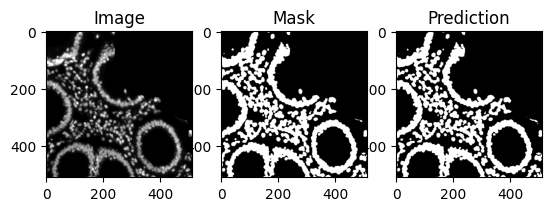

In [29]:
import matplotlib.pyplot as plt

# Get one batch of data from the test loader
data_iter = iter(test_loader)

# Get the first batch of data
data = next(data_iter)

# If you don't like the first batch, get the next one
data = next(data_iter)
data = next(data_iter)
data = next(data_iter)
data = next(data_iter)


inputs, targets = data['image'].to(device), data['mask'].to(device)

# Get the model's output
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    probs = torch.sigmoid(outputs)
    probs  = (probs > 0.5).float()

# Convert tensors to numpy arrays for plotting
image = inputs.cpu().numpy()[0, 0]
mask = targets.cpu().numpy()[0, 0]
pred = probs.cpu().numpy()[0, 0]

# Create a figure
fig = plt.figure()

# Add a subplot for the image
ax1 = fig.add_subplot(1, 3, 1)  # 1 row, 3 columns, first plot
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Image')

# Add a subplot for the mask
ax2 = fig.add_subplot(1, 3, 2)  # 1 row, 3 columns, second plot
ax2.imshow(mask, cmap='gray')
ax2.title.set_text('Mask')

# Add a subplot for the prediction
ax3 = fig.add_subplot(1, 3, 3)  # 1 row, 3 columns, third plot
ax3.imshow(pred, cmap='gray')
ax3.title.set_text('Prediction')

# Display the plot
plt.show()

In [30]:
intersection = (pred * mask).sum()
union = pred.sum() + mask.sum()
dice = (2*intersection) / union
print(f"Dice Coefficient: {dice:.4f}")

Dice Coefficient: 0.9692
